In [98]:
import re  # For preprocessing
import pandas as pd  # For data handling
import spacy  
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import multiprocessing

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# t-SNE visualizations:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load the inclusion/exclusion criteria dataset from clinicaltrials.gov
dataset = pd.read_csv('eligibilities.txt', delimiter="|")
dataset.head()

,id,nct_id,sampling_method,gender,minimum_age,maximum_age,healthy_volunteers,population,criteria,gender_description,gender_based
0,5117200,NCT04100044,NaN,All,65 Years,NaN,No,NaN,~ Inclusion Criteria:~ - Diagn...,NaN,NaN
1,5117201,NCT04100031,NaN,All,60 Years,NaN,No,NaN,~ Inclusion Criteria:~ 1. age-r...,NaN,NaN
2,5117202,NCT04100018,NaN,Male,18 Years,NaN,No,NaN,~ For more information regarding Bristol...,NaN,t
3,5117203,NCT04100005,Probability Sample,All,18 Years,NaN,NaN,Patients who have been diagnosed with Crohn's ...,~ Inclusion Criteria:~ 1. Signe...,NaN,NaN
4,5117204,NCT04099992,NaN,All,40 Years,80 Years,No,NaN,~ Inclusion Criteria:~ - stage...,NaN,NaN


In [4]:
len(dataset)

317412

In [61]:
#removing the records with missing values in the criteria column
elig = dataset.dropna(subset=['criteria']).reset_index(drop=True)

In [65]:
len(elig)

316501

In [90]:
# Convert to list
data = elig.criteria.values.tolist()
# Remove tildes
data = [re.sub('[:~\s+]', ' ', sent) for sent in data]
data = [re.sub(' +', ' ', sent) for sent in data]
print(data[:1])

[" Inclusion Criteria - Diagnosis of multiple myeloma - If patients are undergoing an autologous stem cell transplant, then they will be enrolled after their transplant so that there is not an interruption in the study period - Patients are eligible whether or not they have lytic bone lesions - If they do have lytic lesions, the lesions must be low risk for fracture (low risk by Mirel's score or less than 50% of vertebral body height) - If patients are high risk for bone fracture, they must undergo bone stabilization prior to being considered for enrollment - Patients will have to be at least 6 weeks from date of stabilization - Provide signed and dated informed consent form - Willing to comply with all study procedures and be available for the duration of the study - Subjects need to be within 24 months of their multiple myeloma diagnosis - Subject must be able to stand and walk to perform baseline assessments - Subjects must be able to text message (will need cell phone) - Need to li

In [92]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['inclusion', 'criteria', 'diagnosis', 'of', 'multiple', 'myeloma', 'if', 'patients', 'are', 'undergoing', 'an', 'autologous', 'stem', 'cell', 'transplant', 'then', 'they', 'will', 'be', 'enrolled', 'after', 'their', 'transplant', 'so', 'that', 'there', 'is', 'not', 'an', 'interruption', 'in', 'the', 'study', 'period', 'patients', 'are', 'eligible', 'whether', 'or', 'not', 'they', 'have', 'lytic', 'bone', 'lesions', 'if', 'they', 'do', 'have', 'lytic', 'lesions', 'the', 'lesions', 'must', 'be', 'low', 'risk', 'for', 'fracture', 'low', 'risk', 'by', 'mirel', 'score', 'or', 'less', 'than', 'of', 'vertebral', 'body', 'height', 'if', 'patients', 'are', 'high', 'risk', 'for', 'bone', 'fracture', 'they', 'must', 'undergo', 'bone', 'stabilization', 'prior', 'to', 'being', 'considered', 'for', 'enrollment', 'patients', 'will', 'have', 'to', 'be', 'at', 'least', 'weeks', 'from', 'date', 'of', 'stabilization', 'provide', 'signed', 'and', 'dated', 'informed', 'consent', 'form', 'willing', 'to', 

In [100]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

2019-10-19 16:54:57,772 : INFO : collecting all words and their counts
2019-10-19 16:54:57,780 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-10-19 16:54:59,801 : INFO : PROGRESS: at sentence #10000, processed 1803539 words and 413322 word types
2019-10-19 16:55:01,807 : INFO : PROGRESS: at sentence #20000, processed 3580128 words and 646360 word types
2019-10-19 16:55:03,959 : INFO : PROGRESS: at sentence #30000, processed 5464248 words and 842908 word types
2019-10-19 16:55:05,979 : INFO : PROGRESS: at sentence #40000, processed 7249482 words and 1010711 word types
2019-10-19 16:55:08,015 : INFO : PROGRESS: at sentence #50000, processed 9015843 words and 1160918 word types
2019-10-19 16:55:10,072 : INFO : PROGRESS: at sentence #60000, processed 10798166 words and 1298291 word types
2019-10-19 16:55:12,106 : INFO : PROGRESS: at sentence #70000, processed 12522906 words and 1423381 word types
2019-10-19 16:55:14,192 : INFO : PROGRESS: at sentence #80000, pro

2019-10-19 17:00:29,678 : INFO : Phraser added 50000 phrasegrams
2019-10-19 17:00:57,571 : INFO : Phraser built with 77220 77220 phrasegrams


['inclusion', 'criteria', 'diagnosis', 'of', 'multiple_myeloma', 'if', 'patients', 'are', 'undergoing', 'an', 'autologous_stem', 'cell', 'transplant', 'then', 'they', 'will', 'be', 'enrolled', 'after', 'their', 'transplant', 'so', 'that', 'there', 'is', 'not', 'an', 'interruption', 'in', 'the', 'study', 'period', 'patients', 'are', 'eligible', 'whether', 'or', 'not', 'they', 'have', 'lytic', 'bone', 'lesions', 'if', 'they', 'do', 'have', 'lytic', 'lesions', 'the', 'lesions', 'must', 'be', 'low', 'risk', 'for', 'fracture', 'low', 'risk', 'by', 'mirel', 'score', 'or', 'less', 'than', 'of', 'vertebral', 'body', 'height', 'if', 'patients', 'are', 'high', 'risk', 'for', 'bone', 'fracture', 'they', 'must', 'undergo', 'bone', 'stabilization', 'prior', 'to', 'being', 'considered', 'for', 'enrollment', 'patients', 'will', 'have', 'to', 'be', 'at', 'least', 'weeks', 'from', 'date', 'of', 'stabilization', 'provide', 'signed', 'and', 'dated', 'informed', 'consent', 'form', 'willing', 'to', 'comply

In [101]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [102]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [103]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [106]:
data_words_bigrams[:2]

[['inclusion',
  'criteria',
  'diagnosis',
  'multiple_myeloma',
  'patients',
  'undergoing',
  'autologous',
  'stem',
  'cell',
  'transplant',
  'enrolled',
  'transplant',
  'interruption',
  'study',
  'period',
  'patients',
  'eligible',
  'whether',
  'lytic',
  'bone',
  'lesions',
  'lytic',
  'lesions',
  'lesions',
  'must',
  'low',
  'risk',
  'fracture',
  'low',
  'risk',
  'mirel',
  'score',
  'less',
  'vertebral',
  'body',
  'height',
  'patients',
  'high',
  'risk',
  'bone',
  'fracture',
  'must',
  'undergo',
  'bone',
  'stabilization',
  'prior',
  'considered',
  'enrollment',
  'patients',
  'least',
  'weeks',
  'date',
  'stabilization',
  'provide',
  'signed',
  'dated',
  'informed',
  'consent',
  'form',
  'willing',
  'comply',
  'study',
  'procedures',
  'available',
  'duration',
  'study',
  'subjects',
  'need',
  'within',
  'months',
  'multiple_myeloma',
  'diagnosis',
  'subject',
  'must',
  'able',
  'stand',
  'walk',
  'perform',
  '

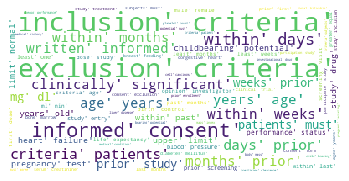

In [110]:
#Word cloud (just )
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(data_words_bigrams))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

### Training in 3 distinctive steps for clarity and monitoring

##### Word2Vec(): 
In this first step, I set up the parameters of the model one-by-one.
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.

##### .build_vocab():
Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

##### .train():
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [111]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

In [112]:
# The parameters:
# min_count = int - Ignores all words with total absolute 
#                   frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word 
#                   within a sentence. E.g. window words on the left and 
#                   window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency 
#                    words are randomly downsampled. 
#                     Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as 
#                        training progresses. To set it: 
#                        alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, 
#                    the int for negative specifies how many "noise words" 
#                    should be drown. If set to 0, no negative sampling 
#                    is used. - (5, 20)
# workers = int - Use these many worker threads to train the model 
#                    (=faster training with multicore machines)

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [113]:
# Building the Vocabulary Table:
# Word2Vec requires us to build the vocabulary table 
# (simply digesting all the words and filtering out the unique words, 
# and doing some basic counts on them):

t = time()

w2v_model.build_vocab(data_words_bigrams, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

2019-10-19 17:38:55,488 : INFO : collecting all words and their counts
2019-10-19 17:38:55,503 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-19 17:38:56,145 : INFO : PROGRESS: at sentence #10000, processed 1192404 words, keeping 34578 word types
2019-10-19 17:38:56,762 : INFO : PROGRESS: at sentence #20000, processed 2366508 words, keeping 47019 word types
2019-10-19 17:38:57,494 : INFO : PROGRESS: at sentence #30000, processed 3610797 words, keeping 56082 word types
2019-10-19 17:38:58,145 : INFO : PROGRESS: at sentence #40000, processed 4788732 words, keeping 63193 word types
2019-10-19 17:38:58,779 : INFO : PROGRESS: at sentence #50000, processed 5952811 words, keeping 69290 word types
2019-10-19 17:38:59,369 : INFO : PROGRESS: at sentence #60000, processed 7129614 words, keeping 74655 word types
2019-10-19 17:38:59,918 : INFO : PROGRESS: at sentence #70000, processed 8269744 words, keeping 79276 word types
2019-10-19 17:39:00,493 : INFO : PROGRE

Time to build vocab: 0.27 mins


In [114]:
# Training of the model:
# Parameters of the training:
# total_examples = int - Count of data_words_bigrams;
# epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

t = time()

w2v_model.train(data_words_bigrams, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

2019-10-19 17:40:24,539 : INFO : training model with 11 workers on 29374 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
2019-10-19 17:40:25,609 : INFO : EPOCH 1 - PROGRESS: at 5.66% examples, 993686 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:40:26,618 : INFO : EPOCH 1 - PROGRESS: at 11.28% examples, 1005931 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:40:27,622 : INFO : EPOCH 1 - PROGRESS: at 16.90% examples, 996961 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:40:28,628 : INFO : EPOCH 1 - PROGRESS: at 22.73% examples, 1002339 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:40:29,629 : INFO : EPOCH 1 - PROGRESS: at 28.74% examples, 1009507 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:40:30,643 : INFO : EPOCH 1 - PROGRESS: at 34.73% examples, 1015540 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:40:31,650 : INFO : EPOCH 1 - PROGRESS: at 40.56% examples, 1017063 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:40:32,653 : INFO : EPOCH 1 - PRO

2019-10-19 17:41:17,345 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 17:41:17,357 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 17:41:17,362 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 17:41:17,364 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 17:41:17,368 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 17:41:17,370 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 17:41:17,372 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 17:41:17,375 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 17:41:17,377 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 17:41:17,383 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 17:41:17,384 : INFO : worker thread finished; awaiting finish of 0 more thread

2019-10-19 17:42:01,449 : INFO : EPOCH 6 - PROGRESS: at 51.48% examples, 1012817 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:42:02,452 : INFO : EPOCH 6 - PROGRESS: at 57.20% examples, 1010474 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:42:03,462 : INFO : EPOCH 6 - PROGRESS: at 62.96% examples, 1008786 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:42:04,476 : INFO : EPOCH 6 - PROGRESS: at 68.72% examples, 1007559 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:42:05,482 : INFO : EPOCH 6 - PROGRESS: at 74.67% examples, 1007724 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:42:06,495 : INFO : EPOCH 6 - PROGRESS: at 80.49% examples, 1006408 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:42:07,500 : INFO : EPOCH 6 - PROGRESS: at 86.33% examples, 1004870 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:42:08,501 : INFO : EPOCH 6 - PROGRESS: at 92.93% examples, 1004517 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:42:09,503 : INFO : EPOCH 6 - PROGRESS: at 97.74% examples, 1006061

2019-10-19 17:42:45,980 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 17:42:45,981 : INFO : EPOCH - 8 : training on 38281503 raw words (17782202 effective words) took 17.8s, 1000051 effective words/s
2019-10-19 17:42:47,006 : INFO : EPOCH 9 - PROGRESS: at 5.66% examples, 996224 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:42:48,018 : INFO : EPOCH 9 - PROGRESS: at 11.22% examples, 1001330 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:42:49,023 : INFO : EPOCH 9 - PROGRESS: at 16.93% examples, 998670 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:42:50,034 : INFO : EPOCH 9 - PROGRESS: at 22.73% examples, 1000874 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:42:51,037 : INFO : EPOCH 9 - PROGRESS: at 28.57% examples, 1002375 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:42:52,045 : INFO : EPOCH 9 - PROGRESS: at 34.48% examples, 1007340 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:42:53,048 : INFO : EPOCH 9 - PROGRESS: at 40.15% examples, 1007462 

2019-10-19 17:43:38,026 : INFO : EPOCH 11 - PROGRESS: at 99.08% examples, 1026740 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:43:38,228 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 17:43:38,240 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 17:43:38,246 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 17:43:38,252 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 17:43:38,256 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 17:43:38,261 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 17:43:38,264 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 17:43:38,266 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 17:43:38,268 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 17:43:38,269 : INFO : worker thread finished; awaitin

2019-10-19 17:44:20,913 : INFO : EPOCH 14 - PROGRESS: at 46.66% examples, 1031129 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:44:21,914 : INFO : EPOCH 14 - PROGRESS: at 52.52% examples, 1031980 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:44:22,919 : INFO : EPOCH 14 - PROGRESS: at 58.53% examples, 1031530 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:44:23,926 : INFO : EPOCH 14 - PROGRESS: at 64.29% examples, 1028425 words/s, in_qsize 18, out_qsize 3
2019-10-19 17:44:24,929 : INFO : EPOCH 14 - PROGRESS: at 70.09% examples, 1027198 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:44:25,931 : INFO : EPOCH 14 - PROGRESS: at 75.79% examples, 1023065 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:44:26,935 : INFO : EPOCH 14 - PROGRESS: at 81.71% examples, 1022134 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:44:27,941 : INFO : EPOCH 14 - PROGRESS: at 87.94% examples, 1022476 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:44:28,943 : INFO : EPOCH 14 - PROGRESS: at 94.29% examples

2019-10-19 17:45:05,691 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 17:45:05,695 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 17:45:05,696 : INFO : EPOCH - 16 : training on 38281503 raw words (17782634 effective words) took 17.7s, 1002909 effective words/s
2019-10-19 17:45:06,728 : INFO : EPOCH 17 - PROGRESS: at 5.58% examples, 976772 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:45:07,728 : INFO : EPOCH 17 - PROGRESS: at 11.22% examples, 1004141 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:45:08,728 : INFO : EPOCH 17 - PROGRESS: at 16.89% examples, 1000280 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:45:09,732 : INFO : EPOCH 17 - PROGRESS: at 22.58% examples, 998169 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:45:10,738 : INFO : EPOCH 17 - PROGRESS: at 28.28% examples, 994635 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:45:11,744 : INFO : EPOCH 17 - PROGRESS: at 34.08% examples, 997314 words/s, in_qsize 2

2019-10-19 17:45:57,694 : INFO : EPOCH 19 - PROGRESS: at 91.68% examples, 992098 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:45:58,699 : INFO : EPOCH 19 - PROGRESS: at 97.07% examples, 995484 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:45:59,429 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 17:45:59,434 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 17:45:59,442 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 17:45:59,446 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 17:45:59,450 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-19 17:45:59,452 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-19 17:45:59,455 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 17:45:59,457 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 17:45:59,459 : INFO : worker t

2019-10-19 17:46:41,937 : INFO : EPOCH 22 - PROGRESS: at 34.86% examples, 873593 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:46:42,941 : INFO : EPOCH 22 - PROGRESS: at 39.74% examples, 871756 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:46:43,947 : INFO : EPOCH 22 - PROGRESS: at 44.09% examples, 865398 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:46:44,953 : INFO : EPOCH 22 - PROGRESS: at 49.02% examples, 864649 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:46:45,956 : INFO : EPOCH 22 - PROGRESS: at 54.66% examples, 875642 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:46:46,957 : INFO : EPOCH 22 - PROGRESS: at 60.39% examples, 885574 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:46:47,961 : INFO : EPOCH 22 - PROGRESS: at 66.07% examples, 893563 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:46:48,967 : INFO : EPOCH 22 - PROGRESS: at 71.98% examples, 901925 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:46:49,975 : INFO : EPOCH 22 - PROGRESS: at 77.84% examples, 908271

2019-10-19 17:47:29,679 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-19 17:47:29,681 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-19 17:47:29,682 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-10-19 17:47:29,684 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-10-19 17:47:29,685 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-10-19 17:47:29,686 : INFO : EPOCH - 24 : training on 38281503 raw words (17777002 effective words) took 17.8s, 998017 effective words/s
2019-10-19 17:47:30,711 : INFO : EPOCH 25 - PROGRESS: at 5.66% examples, 995699 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:47:31,721 : INFO : EPOCH 25 - PROGRESS: at 11.22% examples, 1001841 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:47:32,726 : INFO : EPOCH 25 - PROGRESS: at 17.08% examples, 1008317 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:47:33,728 : INFO : EPOCH 25 - PROGRESS: at 2

2019-10-19 17:48:18,149 : INFO : EPOCH 27 - PROGRESS: at 75.23% examples, 1014869 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:48:19,153 : INFO : EPOCH 27 - PROGRESS: at 81.08% examples, 1014336 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:48:20,144 : INFO : EPOCH 27 - PROGRESS: at 87.10% examples, 1013252 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:48:21,148 : INFO : EPOCH 27 - PROGRESS: at 93.60% examples, 1013833 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:48:22,161 : INFO : EPOCH 27 - PROGRESS: at 98.34% examples, 1014912 words/s, in_qsize 22, out_qsize 2
2019-10-19 17:48:22,543 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-19 17:48:22,549 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-19 17:48:22,555 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-19 17:48:22,559 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-19 17:48:22,561 : INFO : worker thread finished

2019-10-19 17:49:02,151 : INFO : EPOCH 30 - PROGRESS: at 22.96% examples, 1016930 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:49:03,151 : INFO : EPOCH 30 - PROGRESS: at 28.85% examples, 1016868 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:49:04,163 : INFO : EPOCH 30 - PROGRESS: at 34.63% examples, 1015790 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:49:05,174 : INFO : EPOCH 30 - PROGRESS: at 40.30% examples, 1013011 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:49:06,179 : INFO : EPOCH 30 - PROGRESS: at 45.82% examples, 1013222 words/s, in_qsize 20, out_qsize 1
2019-10-19 17:49:07,181 : INFO : EPOCH 30 - PROGRESS: at 51.53% examples, 1012676 words/s, in_qsize 19, out_qsize 2
2019-10-19 17:49:08,183 : INFO : EPOCH 30 - PROGRESS: at 57.42% examples, 1013186 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:49:09,184 : INFO : EPOCH 30 - PROGRESS: at 63.22% examples, 1012310 words/s, in_qsize 21, out_qsize 0
2019-10-19 17:49:10,187 : INFO : EPOCH 30 - PROGRESS: at 68.96% examples

Time to train the model: 8.85 mins


In [115]:
#As we do not plan to train the model any further, we are calling init_sims(), 
#which will make the model much more memory-efficient:
w2v_model.init_sims(replace=True)

2019-10-19 17:50:24,798 : INFO : precomputing L2-norms of word weight vectors


In [116]:
# save model
w2v_model.save('w2v_model.bin')

2019-10-19 17:50:41,427 : INFO : saving Word2Vec object under w2v_model.bin, separately None
2019-10-19 17:50:41,503 : INFO : not storing attribute vectors_norm
2019-10-19 17:50:41,666 : INFO : not storing attribute cum_table
C:\Users\HR2479\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-10-19 17:50:43,203 : INFO : saved w2v_model.bin


In [ ]:
# load model
#new_model = Word2Vec.load('w2v_model.bin')
#print(new_model)

In [136]:
# Similarities:
w2v_model.wv.most_similar(positive=["severe"], topn=50)

[('sever', 0.7351270318031311),
 ('serious', 0.6908068656921387),
 ('uncontrolled', 0.6134951114654541),
 ('dysfunction', 0.603093147277832),
 ('chronic', 0.5985181927680969),
 ('insufficiency', 0.5924909114837646),
 ('acute', 0.5825518369674683),
 ('significant', 0.5783981084823608),
 ('diseases', 0.5775426626205444),
 ('unstable', 0.5649756789207458),
 ('cardiovascular', 0.5617852210998535),
 ('disorders', 0.5539565086364746),
 ('presence', 0.5502365827560425),
 ('moderate', 0.5485018491744995),
 ('obstructive', 0.5479766726493835),
 ('impairment', 0.545627236366272),
 ('cerebrovascular', 0.5419840812683105),
 ('debilitating', 0.5288748145103455),
 ('disease', 0.5263450145721436),
 ('uncompensated', 0.5262557864189148),
 ('suffering', 0.525666356086731),
 ('illness', 0.5220707654953003),
 ('pulmonary', 0.5210614204406738),
 ('uncontrollable', 0.5160142183303833),
 ('failure', 0.5089952945709229),
 ('heart', 0.5089759826660156),
 ('neurological', 0.5073888301849365),
 ('congestive', 0

In [140]:
# Odd-One-Out:
w2v_model.wv.doesnt_match(['severe', 'mild', 'comorbidity'])

'comorbidity'

In [120]:
#Analogy difference: (think ubiquitous example: King - Man + Woman = Queen)
w2v_model.wv.most_similar(positive=["severe", "obesity"], negative=["mild"], topn=3)

[('morbid_obesity', 0.6150376796722412),
 ('diabetes', 0.4548099935054779),
 ('diseases', 0.4324337840080261)]

In [122]:
w2v_model.wv.most_similar(positive=["mild", "obesity"], negative=["uncontrolled"], topn=3)

[('adiposity', 0.42556458711624146),
 ('moderate', 0.41504549980163574),
 ('overweight', 0.4130474328994751)]

In [146]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

C:\Users\HR2479\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
C:\Users\HR2479\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\HR2479\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


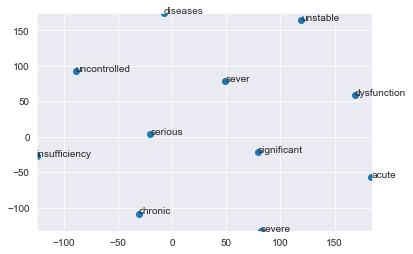

In [147]:
display_closestwords_tsnescatterplot(w2v_model, 'severe')